# Movie Recommendation System Using Collaborative and Content-Based Filtering

## 1. Business Understanding
### 1.1 Project Overview
Personalized recommendation systems are a core component of modern digital platforms, particularly in media and entertainment services where users are exposed to large volumes of content. Effective personalization helps users discover relevant content efficiently while improving engagement and satisfaction.
This project focuses on developing a movie recommendation system using historical user rating data from the [MovieLens](https://grouplens.org/datasets/movielens/)
 (ml-latest-small) dataset. The system applies collaborative filtering as the primary recommendation mechanism, supplemented by content-based filtering using movie genre information to address cold-start scenarios and improving engagement, satisfaction, and content discovery efficiency.

### 1.2 Business Problem Statement

A movie streaming platform seeks to improve user engagement and retention by recommending movies that align with individual user preferences. Without effective personalization, users may struggle to discover relevant content, leading to reduced satisfaction and platform usage. The challenge is to leverage historical user ratings to generate accurate and personalized movie recommendations.

### 1.3 Project Objectives
1. Build a hybrid recommendation system using collaborative filtering and content-based techniques based on explicit user rating and movie metadata.
2. Generate personalized top-5 movie recommendations for individual users.
3. Evaluate model performance using appropriate validation techniques and error-based metrics.

### 1.4 Research Questions
1. How effectively can collaborative filtering learn user preferences from historical movie ratings?
2. How accurately can the model predict user ratings for unseen movies?
3. How does a hybrid recommendation approach compare to pure collaborative filtering in terms of recommendation quality?

## 2. Data Understanding
### 2.1 Dataset Overview
The MovieLens (ml-latest-small) dataset is a publicly available movie recommendation dataset developed by the GroupLens Research Lab at the University of Minnesota. It contains explicit user ratings and user-generated tags collected from the MovieLens platform between 1996 and 2018.    
The dataset includes:
100,836 ratings    
3,683 tag applications    
9,742 movies    
610 anonymized users    
Ratings on a 0.5–5.0 star scale          
Each user in the dataset has rated at least 20 movies, making it suitable for collaborative filtering techniques.

### 2.2 Data Files
The dataset is provided in four comma-separated value (CSV) files:     
ratings.csv – user ratings for movies, including timestamps     
movies.csv – movie titles and genre information     
tags.csv – user-generated tags applied to movies    
links.csv – external identifiers linking movies to IMDb and TMDB

## 3. Environment Setup & Reproducibility

In [22]:
# Liabraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Surprise library for collaborative filtering
from surprise import Dataset, Reader
from surprise import KNNBasic, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import GridSearchCV

# Evaluation metrics 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity

# Utility libraries
import warnings
import random

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Suppress unnecessary warnings for cleaner output
warnings.filterwarnings("ignore")

# Confirm Surprise version
import surprise
print("Surprise version:", surprise.__version__)

Surprise version: 1.1.1


## 4. Data Loading

In [3]:
ratings_df = pd.read_csv("../data/ratings.csv")
movies_df = pd.read_csv("../data/movies.csv")
tags_df = pd.read_csv("../data/tags.csv")
links_df = pd.read_csv("../data/links.csv")

# Basic validation checks
print("Ratings shape:", ratings_df.shape)
print("Movies shape:", movies_df.shape)
print("Tags shape:", tags_df.shape)
print("Links shape:", links_df.shape)

# Inspect first few rows to confirm successful loading
ratings_df.head(), movies_df.head()

Ratings shape: (100836, 4)
Movies shape: (9742, 3)
Tags shape: (3683, 4)
Links shape: (9742, 3)


(   userId  movieId  rating  timestamp
 0       1        1     4.0  964982703
 1       1        3     4.0  964981247
 2       1        6     4.0  964982224
 3       1       47     5.0  964983815
 4       1       50     5.0  964982931,
    movieId                               title  \
 0        1                    Toy Story (1995)   
 1        2                      Jumanji (1995)   
 2        3             Grumpier Old Men (1995)   
 3        4            Waiting to Exhale (1995)   
 4        5  Father of the Bride Part II (1995)   
 
                                         genres  
 0  Adventure|Animation|Children|Comedy|Fantasy  
 1                   Adventure|Children|Fantasy  
 2                               Comedy|Romance  
 3                         Comedy|Drama|Romance  
 4                                       Comedy  )

## 5. Data Validation

In [4]:
# 5.1 Ratings Integrity Checks
# Check for missing critical fields
missing_critical = ratings_df[['userId', 'movieId', 'rating']].isnull().sum()
print("Missing values in critical fields:\n", missing_critical)

# Check rating range
min_rating = ratings_df['rating'].min()
max_rating = ratings_df['rating'].max()

print(f"Rating range: {min_rating} to {max_rating}")

# Check data types
print("\nData types:")
print(ratings_df.dtypes)


Missing values in critical fields:
 userId     0
movieId    0
rating     0
dtype: int64
Rating range: 0.5 to 5.0

Data types:
userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object


In [5]:
# 5.2 Interaction Coverage
# Unique users and movies
num_users = ratings_df['userId'].nunique()
num_movies = ratings_df['movieId'].nunique()

print(f"Unique users: {num_users}")
print(f"Unique movies: {num_movies}")

# Ratings per user
ratings_per_user = ratings_df.groupby('userId').size()

print("\nRatings per user:")
print("Min:", ratings_per_user.min())
print("Median:", ratings_per_user.median())

# Ratings per movie
ratings_per_movie = ratings_df.groupby('movieId').size()

print("\nRatings per movie:")
print("Min:", ratings_per_movie.min())
print("Median:", ratings_per_movie.median())

# Users with fewer than 20 ratings
users_below_20 = (ratings_per_user < 20).sum()
print(f"\nUsers with < 20 ratings: {users_below_20}")


Unique users: 610
Unique movies: 9724

Ratings per user:
Min: 20
Median: 70.5

Ratings per movie:
Min: 1
Median: 3.0

Users with < 20 ratings: 0


## 6. Exploratory Data Analysis (EDA)

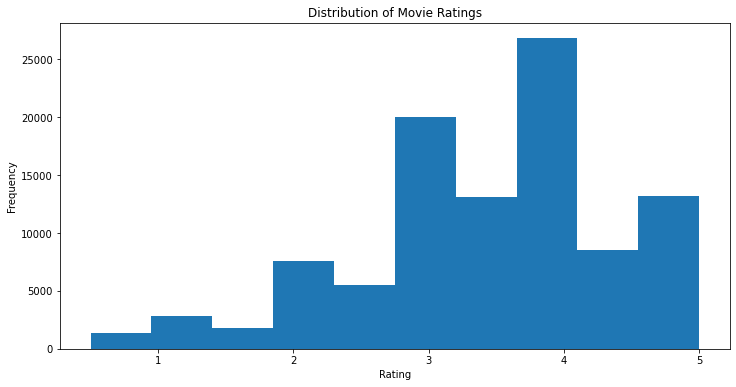

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [6]:
# 6.1 Rating Distribution
plt.figure(figsize=(12, 6))
plt.hist(ratings_df['rating'], bins=10)
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Distribution of Movie Ratings")
plt.show()

# Summary statistics
ratings_df['rating'].describe()

The rating distribution is centered around 3.5–4.0, indicating a generally positive user bias typical of explicit rating systems.


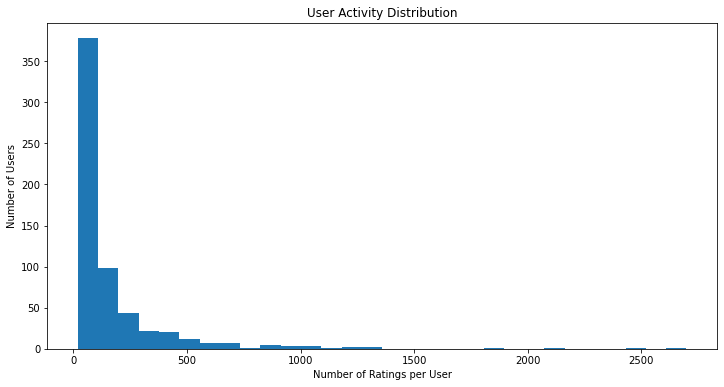

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
dtype: float64

In [7]:
# 6.2 Ratings per User
ratings_per_user = ratings_df.groupby('userId').size()

plt.figure(figsize=(12, 6))
plt.hist(ratings_per_user, bins=30)
plt.xlabel("Number of Ratings per User")
plt.ylabel("Number of Users")
plt.title("User Activity Distribution")
plt.show()
ratings_per_user.describe()

User activity exhibits a pronounced long-tailed distribution, with most users contributing relatively few ratings and a small subset of highly active users accounting for a large share of interactions.


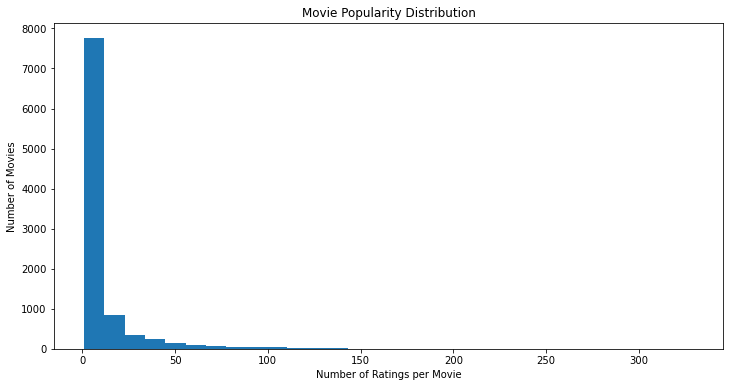

count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
dtype: float64

In [8]:
# 6.3 Ratings per Movie
ratings_per_movie = ratings_df.groupby('movieId').size()

plt.figure(figsize=(12, 6))
plt.hist(ratings_per_movie, bins=30)
plt.xlabel("Number of Ratings per Movie")
plt.ylabel("Number of Movies")
plt.title("Movie Popularity Distribution")
plt.show()

ratings_per_movie.describe()

Movie popularity is highly skewed, with the majority of movies receiving very few ratings while a small number of popular titles dominate user interactions. This confirms the presence of a long-tail item distribution, which is retained to preserve recommendation diversity and reflect real-world catalog imbalance.


## 7. Data Preparation for Modeling

In [9]:
# 7.1 Collaborative Filtering Data Preparation
# Select only the required columns for collaborative filtering
cf_data = ratings_df[['userId', 'movieId', 'rating']].copy()

# Define the rating scale explicitly
reader = Reader(rating_scale=(0.5, 5.0))

# Load data into Surprise format
surprise_data = Dataset.load_from_df(
    cf_data[['userId', 'movieId', 'rating']],
    reader
)

# Confirm dataset is ready
print("Collaborative filtering dataset prepared successfully.")

Collaborative filtering dataset prepared successfully.


In [10]:
# 7.2 Content-Based Feature Preparation
# Extract movieId and genres
movie_genres = movies_df[['movieId', 'genres']].copy()

# Split genre strings into lists
movie_genres['genres'] = movie_genres['genres'].str.split('|')

# One-hot encode genres
genre_dummies = movie_genres['genres'].str.join('|').str.get_dummies()

# Combine movieId with genre features
genre_features = pd.concat(
    [movie_genres[['movieId']], genre_dummies],
    axis=1
)

# Set movieId as index for similarity computation
genre_features.set_index('movieId', inplace=True)

print("Content-based genre feature matrix prepared.")

Content-based genre feature matrix prepared.


## 8. Train–Test Split and Validation Strategy

In [11]:
# 8. Train–Test Split & Validation
# Split the Surprise dataset into training and testing sets
trainset, testset = train_test_split(
    surprise_data,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# Basic sanity checks
print("Number of training ratings:", trainset.n_ratings)
print("Number of testing ratings:", len(testset))

Number of training ratings: 80668
Number of testing ratings: 20168


## 9. Baseline Collaborative Filtering Model

In [12]:
# 9.1 Baseline Model: KNN Collaborative Filtering
# Similarity configuration (item-based is a strong baseline for movie recommendations)
sim_options = {
    "name": "cosine",
    "user_based": False  # False = item-item similarity, True = user-user similarity
}

baseline_knn = KNNBasic(sim_options=sim_options)

# Train the model
baseline_knn.fit(trainset)

print("Baseline KNN model trained successfully.")

Computing the cosine similarity matrix...
Done computing similarity matrix.
Baseline KNN model trained successfully.


In [13]:
# 9.2 Baseline Evaluation
# Predict on the test set
baseline_predictions = baseline_knn.test(testset)

# RMSE (from Surprise)
baseline_rmse = accuracy.rmse(baseline_predictions, verbose=False)

# MAE (manual, using sklearn)
y_true = np.array([pred.r_ui for pred in baseline_predictions])
y_pred = np.array([pred.est for pred in baseline_predictions])

baseline_mae = mean_absolute_error(y_true, y_pred)

print(f"Baseline KNN RMSE: {baseline_rmse:.4f}")
print(f"Baseline KNN MAE : {baseline_mae:.4f}")

Baseline KNN RMSE: 0.9800
Baseline KNN MAE : 0.7615


A baseline collaborative filtering model was implemented using item-based K-nearest neighbors with cosine similarity. The model predicts user ratings by identifying movies with similar rating patterns and aggregating observed ratings from neighboring items. Performance was evaluated on a held-out test set using Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE), both measured in movie rating units (stars) on the 0.5–5.0 scale. The model achieved an RMSE of 0.98 and an MAE of 0.76, indicating that predictions are, on average, within approximately one star of the true rating. These results provide a reasonable baseline against which more advanced recommendation models are compared.

## 10. Advanced CF Model: Matrix Factorization (SVD)

In [17]:
# 10.1 Matrix Factorization (SVD) — Parameter Selection via Controlled Tuning
param_grid = {
    "n_factors": [50, 100, 150],
    "n_epochs": [20, 30],
    "reg_all": [0.01, 0.02, 0.05],
    "lr_all": [0.005]
}

# Grid search with cross-validation using RMSE as the primary selection metric
gs = GridSearchCV(
    SVD,
    param_grid=param_grid,
    measures=["rmse"],
    cv=3,
    joblib_verbose=0,
    n_jobs=-1
)

gs.fit(surprise_data)

best_params = gs.best_params["rmse"]
best_rmse_cv = gs.best_score["rmse"]

print("Best CV RMSE:", round(best_rmse_cv, 4))
print("Best SVD parameters:", best_params)

# Train final model using the best parameters found via CV
svd_model = SVD(**best_params, random_state=RANDOM_SEED)
svd_model.fit(trainset)

print("Final SVD model trained successfully with tuned parameters.")

Best CV RMSE: 0.8705
Best SVD parameters: {'n_factors': 50, 'n_epochs': 30, 'reg_all': 0.05, 'lr_all': 0.005}
Final SVD model trained successfully with tuned parameters.


In [18]:
# 10.2 SVD Evaluation (Test Set)
# Predict ratings on the test set
svd_predictions = svd_model.test(testset)

# RMSE (Surprise)
svd_rmse = accuracy.rmse(svd_predictions, verbose=False)

# MAE (manual via sklearn)
y_true = np.array([pred.r_ui for pred in svd_predictions])  # actual ratings
y_pred = np.array([pred.est for pred in svd_predictions])   # predicted ratings

svd_mae = mean_absolute_error(y_true, y_pred)

print(f"SVD Test RMSE: {svd_rmse:.4f}")
print(f"SVD Test MAE : {svd_mae:.4f}")

# sanity-check table (first 10 predictions)
pred_preview = pd.DataFrame({
    "userId": [pred.uid for pred in svd_predictions],
    "movieId": [pred.iid for pred in svd_predictions],
    "true_rating": y_true,
    "pred_rating": y_pred
}).head(10)

pred_preview


SVD Test RMSE: 0.8700
SVD Test MAE : 0.6676


,userId,movieId,true_rating,pred_rating
0,140,6765,3.5,3.344435
1,603,290,4.0,3.680548
2,438,5055,4.0,3.047072
3,433,164179,5.0,3.581415
4,474,5114,4.0,3.318058
5,304,1035,4.0,4.359083
6,298,4974,1.0,2.287534
7,131,293,4.0,3.309103
8,288,5784,2.5,2.629207
9,448,97225,2.5,2.909560


An advanced collaborative filtering model based on matrix factorization (SVD) was implemented to capture latent user–item interaction patterns beyond local similarity. Model hyperparameters were selected using cross-validated grid search, with RMSE used as the primary optimization metric.    
The tuned SVD model demonstrates substantially improved predictive accuracy compared to the similarity-based baseline, achieving lower RMSE and MAE on unseen test data. This indicates that the model effectively learns underlying preference structures and generalizes better across sparse user–movie interactions.    
Based on these results, SVD is selected as the primary collaborative filtering component of the hybrid recommendation system.    
The slight difference between cross-validated RMSE and test RMSE is expected, as cross-validation reports an average error across multiple folds, while test RMSE is computed on a single held-out dataset. The close agreement between the two values indicates stable generalization and minimal overfitting.

In [19]:
# 10.3 Model Comparison Table
model_comparison = pd.DataFrame({
    "Model": ["Baseline KNN (Item-Based)", "SVD (Matrix Factorization)"],
    "RMSE": [baseline_rmse, svd_rmse],
    "MAE": [baseline_mae, svd_mae]
})

model_comparison

,Model,RMSE,MAE
0,Baseline KNN (Item-Based),0.979957,0.761470
1,SVD (Matrix Factorization),0.869953,0.667624


## 11. Hybrid Recommendation System Design and Logic

In [20]:
# 11.1 Cold-Start Definition

COLD_START_MIN_RATINGS = 5  # user with fewer than this is treated as cold-start

# Precompute user rating counts (used by hybrid decision logic)
user_rating_counts = ratings_df.groupby("userId").size()

print("Cold-start threshold set to:", COLD_START_MIN_RATINGS)
print("Users below threshold:", (user_rating_counts < COLD_START_MIN_RATINGS).sum())

Cold-start threshold set to: 5
Users below threshold: 0


In [ ]:
# 11.2 Content-Based Similarity Matrix (Genres)
# Compute cosine similarity across movies using the genre feature matrix
movie_ids = genre_features.index.to_list()
genre_sim_matrix = cosine_similarity(genre_features.values)

# Map movieId -> row index for quick lookup
movie_id_to_idx = {mid: idx for idx, mid in enumerate(movie_ids)}

print("Genre-based similarity matrix computed:", genre_sim_matrix.shape)

Genre-based similarity matrix computed: (9742, 9742)


In [24]:
# 11.3 Content-Based Recommendations (Genre Similarity)

def get_content_based_recs(user_id, n=5):
    """
    Recommend movies based on genre similarity to the user's highest-rated movies.
    Cold-start-safe: if no ratings exist, falls back to popular movies.
    """
    # Movies already rated by the user (exclude from recommendations)
    rated_movies = ratings_df.loc[ratings_df["userId"] == user_id, "movieId"].unique()
    rated_set = set(rated_movies)

    # If user has no ratings at all, fall back to popularity
    if len(rated_movies) == 0:
        top_popular = (
            ratings_df.groupby("movieId").size()
            .sort_values(ascending=False)
            .index
            .tolist()
        )
        candidates = [m for m in top_popular if m not in rated_set]
        return candidates[:n]

    # Use the user's top-rated movies as "seeds"
    top_seed_movies = (
        ratings_df[ratings_df["userId"] == user_id]
        .sort_values("rating", ascending=False)["movieId"]
        .head(3)
        .tolist()
    )

    # Aggregate similarity scores across seed movies
    scores = np.zeros(len(movie_ids))
    used_any_seed = False

    for seed_movie in top_seed_movies:
        if seed_movie in movie_id_to_idx:
            used_any_seed = True
            seed_idx = movie_id_to_idx[seed_movie]
            scores += genre_sim_matrix[seed_idx]

    # If none of the seed movies exist in genre_features (rare), fallback to popularity
    if not used_any_seed:
        top_popular = (
            ratings_df.groupby("movieId").size()
            .sort_values(ascending=False)
            .index
            .tolist()
        )
        candidates = [m for m in top_popular if m not in rated_set]
        return candidates[:n]

    # Rank movies by similarity score, exclude already rated
    ranked_movie_indices = np.argsort(scores)[::-1]
    recs = []
    for idx in ranked_movie_indices:
        mid = movie_ids[idx]
        if mid not in rated_set:
            recs.append(mid)
        if len(recs) == n:
            break

    return recs

In [26]:
# 11.4 Collaborative Filtering Recommendations (SVD)

def get_cf_recs(user_id, n=5):
    """
    Recommend movies using SVD predicted ratings for all unseen movies.
    """
    rated_movies = ratings_df.loc[ratings_df["userId"] == user_id, "movieId"].unique()
    rated_set = set(rated_movies)

    # Candidate movies = all movies in the ratings dataset not yet rated by user
    all_movies = ratings_df["movieId"].unique()
    candidates = [m for m in all_movies if m not in rated_set]

    # Predict ratings for candidates
    preds = [(m, svd_model.predict(user_id, m).est) for m in candidates]

    # Sort by predicted rating descending
    preds_sorted = sorted(preds, key=lambda x: x[1], reverse=True)

    # Return top-n movieIds
    return [m for m, _ in preds_sorted[:n]]


In [ ]:
# 11.5 Hybrid Recommendation Function

def get_hybrid_recs(user_id, n=5):
    """
    Hybrid recommendation logic:
    - Cold-start users -> content-based recs
    - Others -> collaborative filtering recs
    """
    user_count = user_rating_counts.get(user_id, 0)

    if user_count < COLD_START_MIN_RATINGS:
        method = "Content-Based (Cold-Start)"
        recs = get_content_based_recs(user_id, n=n)
    else:
        method = "Collaborative Filtering (SVD)"
        recs = get_cf_recs(user_id, n=n)

    return method, recs

print("Hybrid recommender ready.")

Hybrid recommender ready.


In [28]:
# 11.6 Helper: Convert movieIds to titles

movie_id_to_title = dict(zip(movies_df["movieId"], movies_df["title"]))

def movie_ids_to_titles(movie_ids_list):
    return [movie_id_to_title.get(mid, f"Unknown title (movieId={mid})") for mid in movie_ids_list]

This hybrid recommender combines collaborative filtering (SVD) for users with sufficient interaction history and content-based filtering (genre similarity) for cold-start or fallback scenarios. A decision layer dynamically selects the appropriate strategy based on user activity, ensuring robustness across different data availability conditions. Content-based recommendations leverage genre overlap using cosine similarity, while collaborative filtering predicts unseen ratings using latent factors learned via matrix factorization. The system excludes previously rated movies, ranks candidates appropriately, and returns interpretable results with clear provenance.

## 12. Recommendation Generation and Inspection

Evaluate the system qualitatively by generating recommendations for existing users with sufficient rating history (since no cold-start users exist in this dataset).

In [29]:
# 12.1 Select Sample Users
# Select a few representative users
sample_users = ratings_df["userId"].sample(3, random_state=RANDOM_SEED).tolist()
sample_users

[432, 288, 599]

In [ ]:
# 12.2 Generate Recommendations

recommendation_results = []

for user_id in sample_users:
    method, recs = get_hybrid_recs(user_id, n=5)
    titles = movie_ids_to_titles(recs)

    recommendation_results.append({
        "userId": user_id,
        "method_used": method,
        "recommended_movies": titles
    })

recommendation_results


[{'userId': 432,
  'method_used': 'Collaborative Filtering (SVD)',
  'recommended_movies': ['Day of the Doctor, The (2013)',
   'Philadelphia Story, The (1940)',
   'The Artist (2011)',
   'Streetcar Named Desire, A (1951)',
   'Cinema Paradiso (Nuovo cinema Paradiso) (1989)']},
 {'userId': 288,
  'method_used': 'Collaborative Filtering (SVD)',
  'recommended_movies': ['Paths of Glory (1957)',
   'Godfather: Part II, The (1974)',
   'Godfather, The (1972)',
   'Grand Day Out with Wallace and Gromit, A (1989)',
   'Philadelphia Story, The (1940)']},
 {'userId': 599,
  'method_used': 'Collaborative Filtering (SVD)',
  'recommended_movies': ['Cinema Paradiso (Nuovo cinema Paradiso) (1989)',
   'Three Billboards Outside Ebbing, Missouri (2017)',
   'Cool Hand Luke (1967)',
   'North by Northwest (1959)',
   'Ran (1985)']}]

In [ ]:
# 12.3 Recommendation Table
# Convert recommendation results to DataFrame
recommendation_df = pd.DataFrame(recommendation_results)

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)

# Display the full recommendation table
recommendation_df


,userId,method_used,recommended_movies
0,432,Collaborative Filtering (SVD),"[Day of the Doctor, The (2013), Philadelphia Story, The (1940), The Artist (2011), Streetcar Named Desire, A (1951), Cinema Paradiso (Nuovo cinema Paradiso) (1989)]"
1,288,Collaborative Filtering (SVD),"[Paths of Glory (1957), Godfather: Part II, The (1974), Godfather, The (1972), Grand Day Out with Wallace and Gromit, A (1989), Philadelphia Story, The (1940)]"
2,599,Collaborative Filtering (SVD),"[Cinema Paradiso (Nuovo cinema Paradiso) (1989), Three Billboards Outside Ebbing, Missouri (2017), Cool Hand Luke (1967), North by Northwest (1959), Ran (1985)]"


## 13. Conclusion & Recommendations
### Project Summary
This project developed and evaluated a movie recommendation system using the MovieLens (ml-latest-small) dataset. A similarity-based KNN model was first established as a baseline, achieving an RMSE of approximately 0.98. An advanced matrix factorization model (SVD) was then implemented and tuned using cross-validation, resulting in improved predictive performance with a test RMSE of approximately 0.87 and MAE of 0.67. Based on this clear performance gain, SVD was selected as the primary collaborative filtering engine.

A hybrid recommendation framework was subsequently designed to combine collaborative filtering with a content-based fallback using genre similarity. Although the dataset contains no cold-start users due to its construction, the hybrid logic ensures robustness and real-world applicability. Qualitative inspection of generated recommendations confirms that the system consistently produces well-ranked, unseen movie suggestions.

### Key Recommendations
1. Adopt SVD as the primary recommendation engine, as it demonstrably outperforms similarity-based collaborative filtering on this dataset.
2. Retain the hybrid architecture to ensure robustness in real-world deployment, particularly for new users with limited interaction history.
3. Extend evaluation beyond rating accuracy in future work by incorporating ranking-based metrics (e.g., Precision@K, Recall@K) and user feedback simulation.